In [1]:
import pandas as pd
from libri_dataframe import build_librispeech_dataframe

#LIBRISPEECH_ROOT = "./my_librispeech/LibriSpeech"
LIBRISPEECH_ROOT = "/mnt/ddn/kyudan/Deepfake-speech/my_raw_audio/LibriSpeech" #for Kyudan
LIBRISPEECH_SUBSET = "test-clean"

dataframe = build_librispeech_dataframe(
    librispeech_root=LIBRISPEECH_ROOT,
    subset=LIBRISPEECH_SUBSET,
)


Loaded 2620 utterances from /mnt/ddn/kyudan/Deepfake-speech/my_raw_audio/LibriSpeech/test-clean
  - Speakers: 40
  - Chapters: 87


In [2]:
dataframe_10 = dataframe[:10]

In [3]:
dataframe_10

,speaker_id,chapter_id,utterance_id,transcript,audio_path
0,1089,134686,1089-134686-0000,HE HOPED THERE WOULD BE STEW FOR DINNER TURNIP...,/mnt/ddn/kyudan/Deepfake-speech/my_raw_audio/L...
1,1089,134686,1089-134686-0001,STUFF IT INTO YOU HIS BELLY COUNSELLED HIM,/mnt/ddn/kyudan/Deepfake-speech/my_raw_audio/L...
2,1089,134686,1089-134686-0002,AFTER EARLY NIGHTFALL THE YELLOW LAMPS WOULD L...,/mnt/ddn/kyudan/Deepfake-speech/my_raw_audio/L...
3,1089,134686,1089-134686-0003,HELLO BERTIE ANY GOOD IN YOUR MIND,/mnt/ddn/kyudan/Deepfake-speech/my_raw_audio/L...
4,1089,134686,1089-134686-0004,NUMBER TEN FRESH NELLY IS WAITING ON YOU GOOD ...,/mnt/ddn/kyudan/Deepfake-speech/my_raw_audio/L...
5,1089,134686,1089-134686-0005,THE MUSIC CAME NEARER AND HE RECALLED THE WORD...,/mnt/ddn/kyudan/Deepfake-speech/my_raw_audio/L...
6,1089,134686,1089-134686-0006,THE DULL LIGHT FELL MORE FAINTLY UPON THE PAGE...,/mnt/ddn/kyudan/Deepfake-speech/my_raw_audio/L...
7,1089,134686,1089-134686-0007,A COLD LUCID INDIFFERENCE REIGNED IN HIS SOUL,/mnt/ddn/kyudan/Deepfake-speech/my_raw_audio/L...
8,1089,134686,1089-134686-0008,THE CHAOS IN WHICH HIS ARDOUR EXTINGUISHED ITS...,/mnt/ddn/kyudan/Deepfake-speech/my_raw_audio/L...
9,1089,134686,1089-134686-0009,AT MOST BY AN ALMS GIVEN TO A BEGGAR WHOSE BLE...,/mnt/ddn/kyudan/Deepfake-speech/my_raw_audio/L...


# librispeech 6930speaker 목소리로 음성 합성

In [4]:
import subprocess
import os
import time
import soundfile as sf
from pathlib import Path

# 1. 설정
OUTPUT_DIR = Path("generated_results_F5_Fixed").resolve()
PROMPT_WAV_DIR = Path("prompt_wav_files").resolve()  # prompt를 wav로 변환해서 저장
CUDA_DEVICE = "3" 

os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(PROMPT_WAV_DIR, exist_ok=True)

def resolve_path(path_str):
    return str(Path(path_str).resolve())

def get_audio_duration(file_path):
    """오디오 파일의 길이를 초 단위로 반환"""
    try:
        with sf.SoundFile(file_path) as f:
            duration = len(f) / f.samplerate
        return duration
    except Exception as e:
        print(f"⚠️ 오디오 길이 측정 실패: {file_path}")
        print(f"   에러: {e}")
        return 0

def convert_to_wav(input_path, output_path):
    """오디오 파일(.flac 등)을 WAV 포맷으로 변환 - soundfile만 사용"""
    try:
        # soundfile로 읽기 (FLAC, WAV 등 지원)
        data, samplerate = sf.read(input_path)
        # WAV로 저장
        sf.write(output_path, data, samplerate)
        return True
    except Exception as e:
        print(f"⚠️ WAV 변환 실패: {input_path}")
        print(f"   에러: {e}")
        return False

def normalize_text(text):
    """텍스트를 F5-TTS에 맞게 정규화"""
    text = text.lower()  # 소문자로 변환
    text = ' '.join(text.split())  # 여러 공백을 하나로
    text = text.strip()
    if not text.endswith(('.', '!', '?', ',')):
        text += '.'  # 마침표 추가
    return text

def save_audio(text, prompt_text, filename, prompt_wav_path=None, seed=None):
    output_path = os.path.join(OUTPUT_DIR, filename)
    
    # 텍스트 정규화
    gen_text = normalize_text(text)
    ref_text = normalize_text(prompt_text)
    
    # 전체 텍스트 출력 (디버깅)
    print(f"  [생성 텍스트] {gen_text}")
    print(f"  [참조 텍스트] {ref_text}")
    
    cmd = [
        "f5-tts_infer-cli",
        "-m", "F5TTS_v1_Base",
        "-r", prompt_wav_path,  # reference audio
        "-s", ref_text,         # reference text
        "-t", gen_text,         # generation text
        "-w", output_path,      # output file
    ]
    
    try:
        start_time = time.time()
        env = os.environ.copy()
        env["CUDA_VISIBLE_DEVICES"] = CUDA_DEVICE if CUDA_DEVICE else ""
        
        result = subprocess.run(cmd, capture_output=True, text=True, check=False, env=env)
        elapsed = time.time() - start_time
        
        if result.returncode == 0 and os.path.exists(output_path):
            print(f"  ✅ 저장 완료: {filename} (소요: {elapsed:.1f}초)")
        else:
            print(f"  ❌ CLI 에러: {filename}")
            if result.stderr:
                stderr_lines = result.stderr.strip().split('\n')
                print(f"     Error: {stderr_lines[-1] if stderr_lines else result.stderr[:200]}")

    except Exception as e:
        print(f"  ❌ 예외 발생: {e}")

# 2. 데이터 준비 및 프롬프트 선정
all_records = dataframe[['speaker_id', 'transcript', 'audio_path']].to_dict('records')
speaker_prompt_lookup = {}

print("=== Speaker별 최적 프롬프트 선정 및 WAV 변환 중... ===")
for row in all_records:
    spk_id = row['speaker_id']
    audio_path = resolve_path(row['audio_path'])
    
    if spk_id in speaker_prompt_lookup:
        continue
        
    if not os.path.exists(audio_path):
        continue
        
    # 오디오 길이 체크 (3~10초)
    dur = get_audio_duration(audio_path)
    if 3.0 <= dur <= 10.0:
        # WAV 파일로 변환
        wav_filename = f"prompt_speaker_{spk_id}.wav"
        wav_path = PROMPT_WAV_DIR / wav_filename
        
        # 이미 변환된 파일이 있으면 스킵
        if not wav_path.exists():
            print(f"  Speaker {spk_id}: {dur:.2f}초 - WAV로 변환 중...")
            if not convert_to_wav(audio_path, str(wav_path)):
                continue
        else:
            print(f"  Speaker {spk_id}: {dur:.2f}초 - 이미 WAV 파일 존재")
        
        speaker_prompt_lookup[spk_id] = {
            'prompt_text': row['transcript'],
            'prompt_wav_path': str(wav_path),
            'original_audio_path': audio_path,
            'duration': dur
        }

print(f"\n총 {len(speaker_prompt_lookup)}명의 화자에 대한 유효 프롬프트 선정 완료.\n")

# 프롬프트 확인 (전체 텍스트 출력)
print("=== Prompt Audio-Transcript Verification (샘플 5개) ===")
for speaker_id, prompt_info in list(speaker_prompt_lookup.items())[:5]:
    print(f"\nSpeaker {speaker_id} (Duration: {prompt_info['duration']:.2f}초)")
    print(f"  Original: .../{Path(prompt_info['original_audio_path']).name}")
    print(f"  WAV:      .../{Path(prompt_info['prompt_wav_path']).name}")
    print(f"  Text:     {normalize_text(prompt_info['prompt_text'])}")
print("=" * 60)

# 입력 데이터 구성
input_rows = dataframe_10[['transcript', 'audio_path', 'speaker_id']].to_dict('records')
input_data = []

for idx, row in enumerate(input_rows):
    spk_id = row['speaker_id']
    
    if spk_id in speaker_prompt_lookup:
        prompt = speaker_prompt_lookup[spk_id]
    else:
        print(f"⚠️ 화자 {spk_id}: 적절한 길이의 프롬프트를 찾지 못함, 현재 파일 사용")
        # 현재 파일도 WAV로 변환
        current_wav_path = PROMPT_WAV_DIR / f"fallback_{idx}_{spk_id}.wav"
        if not current_wav_path.exists():
            convert_to_wav(resolve_path(row['audio_path']), str(current_wav_path))
        
        prompt = {
            'prompt_text': row['transcript'],
            'prompt_wav_path': str(current_wav_path)
        }

    input_data.append({
        "text": row['transcript'],
        "filename": f"gen_{idx:03d}_{spk_id}.wav",
        "prompt_text": prompt['prompt_text'],
        "prompt_wav_path": prompt['prompt_wav_path'],
        "seed": 2024 + idx
    })

# 3. 실행
if __name__ == "__main__":
    print(f"\n{'='*60}")
    print(f"총 {len(input_data)}개의 오디오 생성 시작")
    print(f"{'='*60}\n")
    
    for idx, item in enumerate(input_data, start=1):
        print(f"\n[{idx:02d}/{len(input_data):02d}] 원본 텍스트:")
        print(f"  {item['text']}")
        print(f"  프롬프트 WAV: {Path(item['prompt_wav_path']).name}")
        save_audio(**item)


=== Speaker별 최적 프롬프트 선정 및 WAV 변환 중... ===
  Speaker 1089: 3.27초 - WAV로 변환 중...
  Speaker 1188: 9.04초 - WAV로 변환 중...
  Speaker 121: 8.46초 - WAV로 변환 중...
  Speaker 1221: 4.83초 - WAV로 변환 중...
  Speaker 1284: 8.12초 - WAV로 변환 중...
  Speaker 1320: 9.52초 - WAV로 변환 중...
  Speaker 1580: 8.94초 - WAV로 변환 중...
  Speaker 1995: 9.48초 - WAV로 변환 중...
  Speaker 2094: 8.03초 - WAV로 변환 중...
  Speaker 2300: 5.08초 - WAV로 변환 중...
  Speaker 237: 8.92초 - WAV로 변환 중...
  Speaker 260: 7.04초 - WAV로 변환 중...
  Speaker 2830: 6.12초 - WAV로 변환 중...
  Speaker 2961: 8.25초 - WAV로 변환 중...
  Speaker 3570: 5.67초 - WAV로 변환 중...
  Speaker 3575: 8.23초 - WAV로 변환 중...
  Speaker 3729: 8.78초 - WAV로 변환 중...
  Speaker 4077: 9.56초 - WAV로 변환 중...
  Speaker 4446: 3.50초 - WAV로 변환 중...
  Speaker 4507: 3.19초 - WAV로 변환 중...
  Speaker 4970: 3.03초 - WAV로 변환 중...
  Speaker 4992: 6.64초 - WAV로 변환 중...
  Speaker 5105: 4.51초 - WAV로 변환 중...
  Speaker 5142: 5.02초 - WAV로 변환 중...
  Speaker 5639: 8.91초 - WAV로 변환 중...
  Speaker 5683: 3.51초 - WAV로 변환 중...

KeyboardInterrupt: 

In [10]:
import matplotlib.pyplot as plt
import torchaudio
import torch
import numpy as np
from pathlib import Path

# (기존과 동일)
def compute_mel_spectrogram(audio_path, n_mels=80):
    try:
        waveform, sr = torchaudio.load(audio_path)
        mel = torchaudio.transforms.MelSpectrogram(
            sample_rate=sr, n_fft=1024, hop_length=256, n_mels=n_mels, normalized=True
        )(waveform)
        mel_db = torchaudio.functional.amplitude_to_DB(mel, multiplier=10.0, amin=1e-10, db_multiplier=1.0)
        return mel_db.squeeze(0)
    except Exception as e:
        print(f"Error loading {audio_path}: {e}")
        return None

# (기존과 동일)
def compute_gradient_field(mel_tensor):
    mel_np = mel_tensor.numpy()
    grad_y, grad_x = np.gradient(mel_np)
    gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)
    grad_variance = np.var(gradient_magnitude)
    grad_mean = np.mean(gradient_magnitude)
    return gradient_magnitude, grad_variance, grad_mean

# (기존과 동일)
def plot_analysis(ax_spec, ax_grad, mel_tensor, title, grad_stats):
    ax_spec.imshow(mel_tensor.numpy(), origin='lower', aspect='auto', cmap='inferno')
    ax_spec.set_title(f"{title}\n(Log-Mel)", fontsize=10)
    ax_spec.axis('off')
    
    grad_mag, var, mean = compute_gradient_field(mel_tensor)
    ax_grad.imshow(grad_mag, origin='lower', aspect='auto', cmap='gray')
    
    stat_text = f"Grad Var: {var:.2f}\nGrad Mean: {mean:.2f}"
    ax_grad.text(0.02, 0.95, stat_text, transform=ax_grad.transAxes, color='cyan', 
                 fontsize=9, verticalalignment='top', fontweight='bold')
    ax_grad.set_title("Gradient Field", fontsize=10)
    ax_grad.axis('off')
    return grad_stats

# --- 수정된 부분: 이름은 그대로 두되, 내용은 2개만 비교 ---
def visualize_triplet_analysis(row):
    base_name = Path(row['audio_path']).stem
    
    # Gen 1 (Likely TTS)을 리스트에서 삭제했습니다.
    targets = [
        (Path(row['audio_path']).resolve(), "Original (Real)"),
        (Path(f"generated_results/speaker_libri_transcript_{base_name}.wav"), "Gen 2 (Voice Conversion)"),
    ]

    # 열(column) 개수가 2개이므로 figsize를 가로로 조금 줄였습니다 (15 -> 10)
    fig, axes = plt.subplots(2, len(targets), figsize=(10, 3))
    
    stats_list = []

    for idx, (audio_path, label) in enumerate(targets):
        # axes가 2차원 배열이므로 [행, 열] 인덱싱
        ax_spec = axes[0, idx] 
        ax_grad = axes[1, idx] 
        
        if not audio_path.exists():
            ax_spec.text(0.5, 0.5, "File Not Found", ha='center')
            ax_spec.axis('off')
            ax_grad.axis('off')
            stats_list.append(None)
            continue
            
        mel = compute_mel_spectrogram(str(audio_path))
        
        if mel is not None:
            _, var, mean = compute_gradient_field(mel)
            plot_analysis(ax_spec, ax_grad, mel, label, (var, mean))
            stats_list.append({'label': label, 'var': var, 'mean': mean})
        else:
            ax_spec.text(0.5, 0.5, "Load Error", ha='center')
            ax_spec.axis('off')
            ax_grad.axis('off')
            stats_list.append(None)

    fig.suptitle(f"Gradient Analysis: {base_name}", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # 텍스트 리포트
    print(f"--- Analysis Report for {base_name} ---")
    if stats_list and stats_list[0] is not None:
        real_var = stats_list[0]['var']
        print(f"Real Audio Gradient Variance: {real_var:.4f}")
        
        for stat in stats_list[1:]:
            if stat:
                diff = stat['var'] - real_var
                print(f"[{stat['label']}] Diff from Real: {diff:.4f}")
    print("-" * 50)

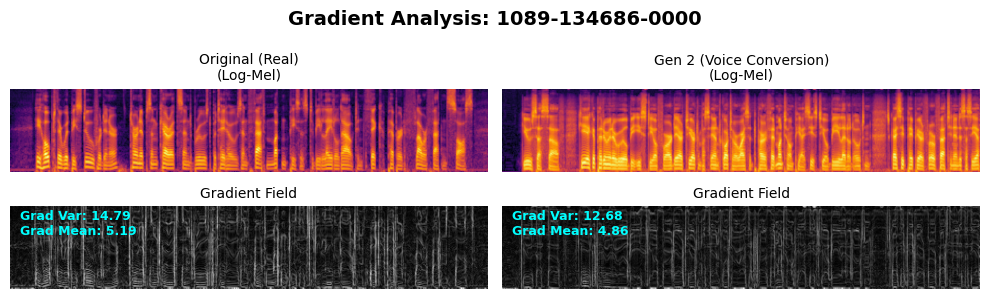

--- Analysis Report for 1089-134686-0000 ---
Real Audio Gradient Variance: 14.7907
[Gen 2 (Voice Conversion)] Diff from Real: -2.1139
--------------------------------------------------


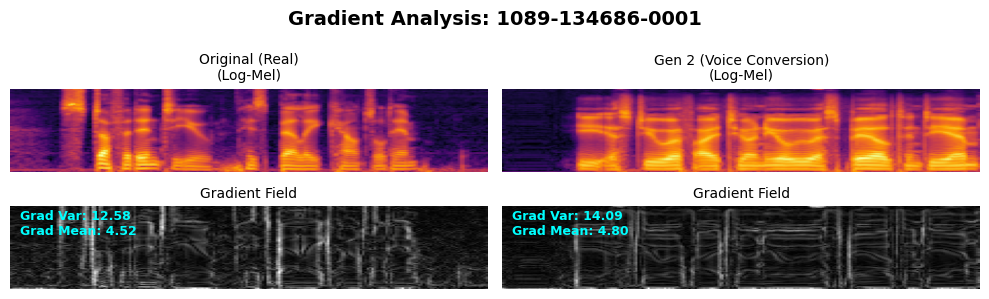

--- Analysis Report for 1089-134686-0001 ---
Real Audio Gradient Variance: 12.5803
[Gen 2 (Voice Conversion)] Diff from Real: 1.5081
--------------------------------------------------


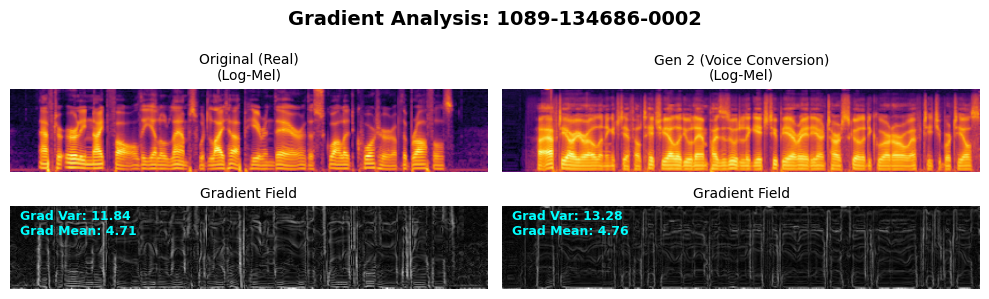

--- Analysis Report for 1089-134686-0002 ---
Real Audio Gradient Variance: 11.8414
[Gen 2 (Voice Conversion)] Diff from Real: 1.4338
--------------------------------------------------


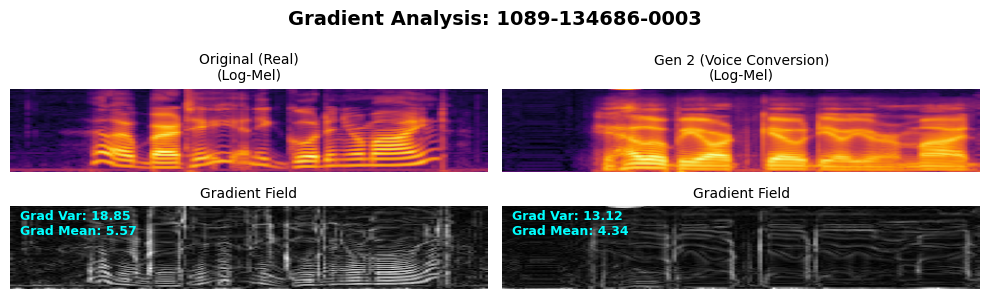

--- Analysis Report for 1089-134686-0003 ---
Real Audio Gradient Variance: 18.8482
[Gen 2 (Voice Conversion)] Diff from Real: -5.7315
--------------------------------------------------


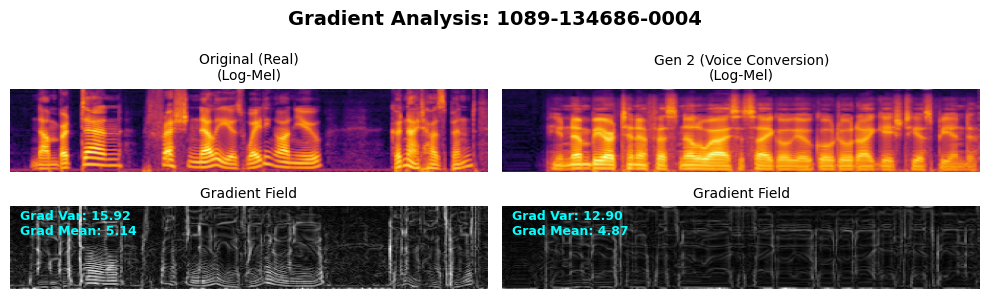

--- Analysis Report for 1089-134686-0004 ---
Real Audio Gradient Variance: 15.9219
[Gen 2 (Voice Conversion)] Diff from Real: -3.0267
--------------------------------------------------


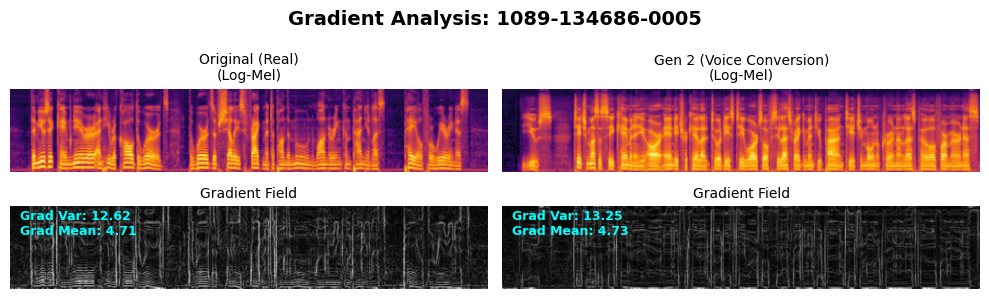

--- Analysis Report for 1089-134686-0005 ---
Real Audio Gradient Variance: 12.6217
[Gen 2 (Voice Conversion)] Diff from Real: 0.6237
--------------------------------------------------


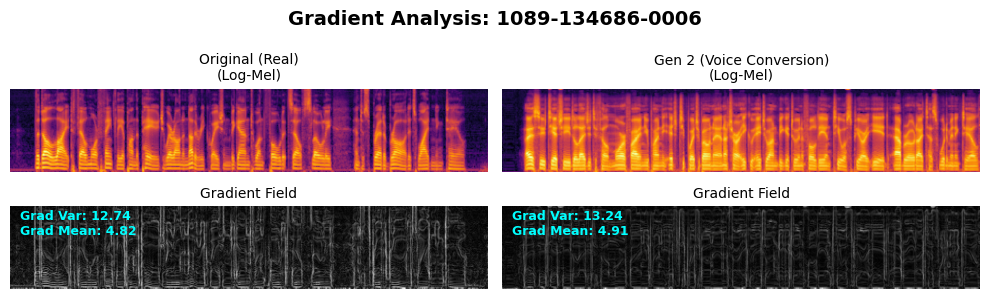

--- Analysis Report for 1089-134686-0006 ---
Real Audio Gradient Variance: 12.7444
[Gen 2 (Voice Conversion)] Diff from Real: 0.4911
--------------------------------------------------


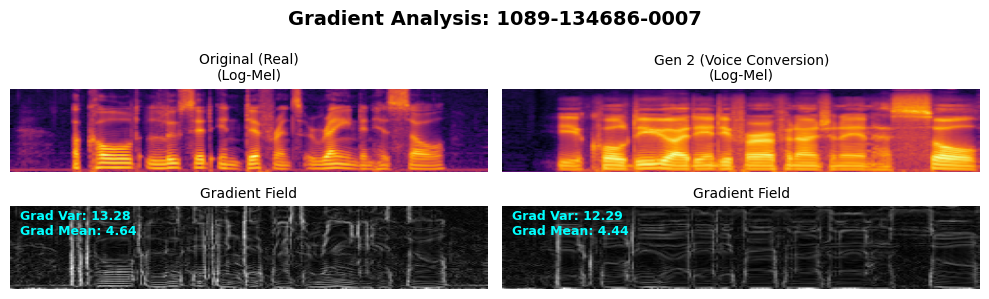

--- Analysis Report for 1089-134686-0007 ---
Real Audio Gradient Variance: 13.2849
[Gen 2 (Voice Conversion)] Diff from Real: -0.9964
--------------------------------------------------


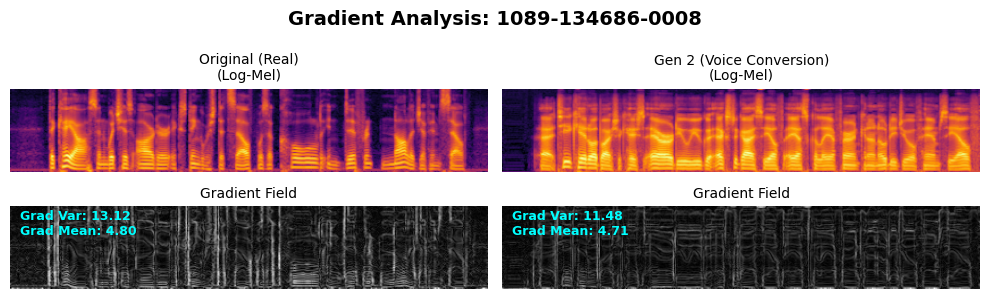

--- Analysis Report for 1089-134686-0008 ---
Real Audio Gradient Variance: 13.1154
[Gen 2 (Voice Conversion)] Diff from Real: -1.6377
--------------------------------------------------


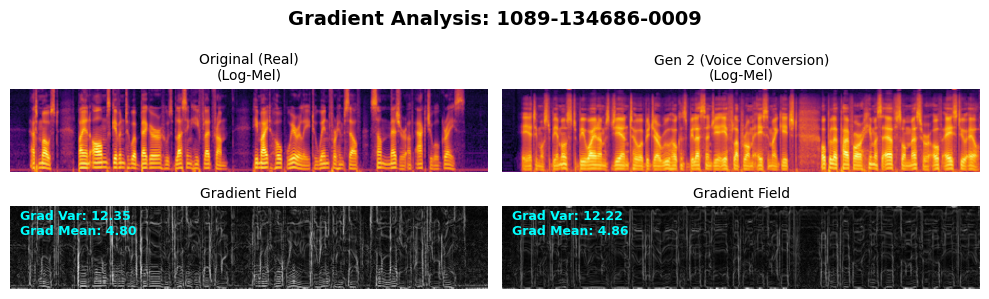

--- Analysis Report for 1089-134686-0009 ---
Real Audio Gradient Variance: 12.3545
[Gen 2 (Voice Conversion)] Diff from Real: -0.1372
--------------------------------------------------


In [11]:

#실행 예시 (dataframe_10이 정의되어 있다고 가정)
for row in dataframe_10.to_dict('records'):
    visualize_triplet_analysis(row)

Processed 10 rows...
Data collection complete. Plotting results...
Drawing arrows...


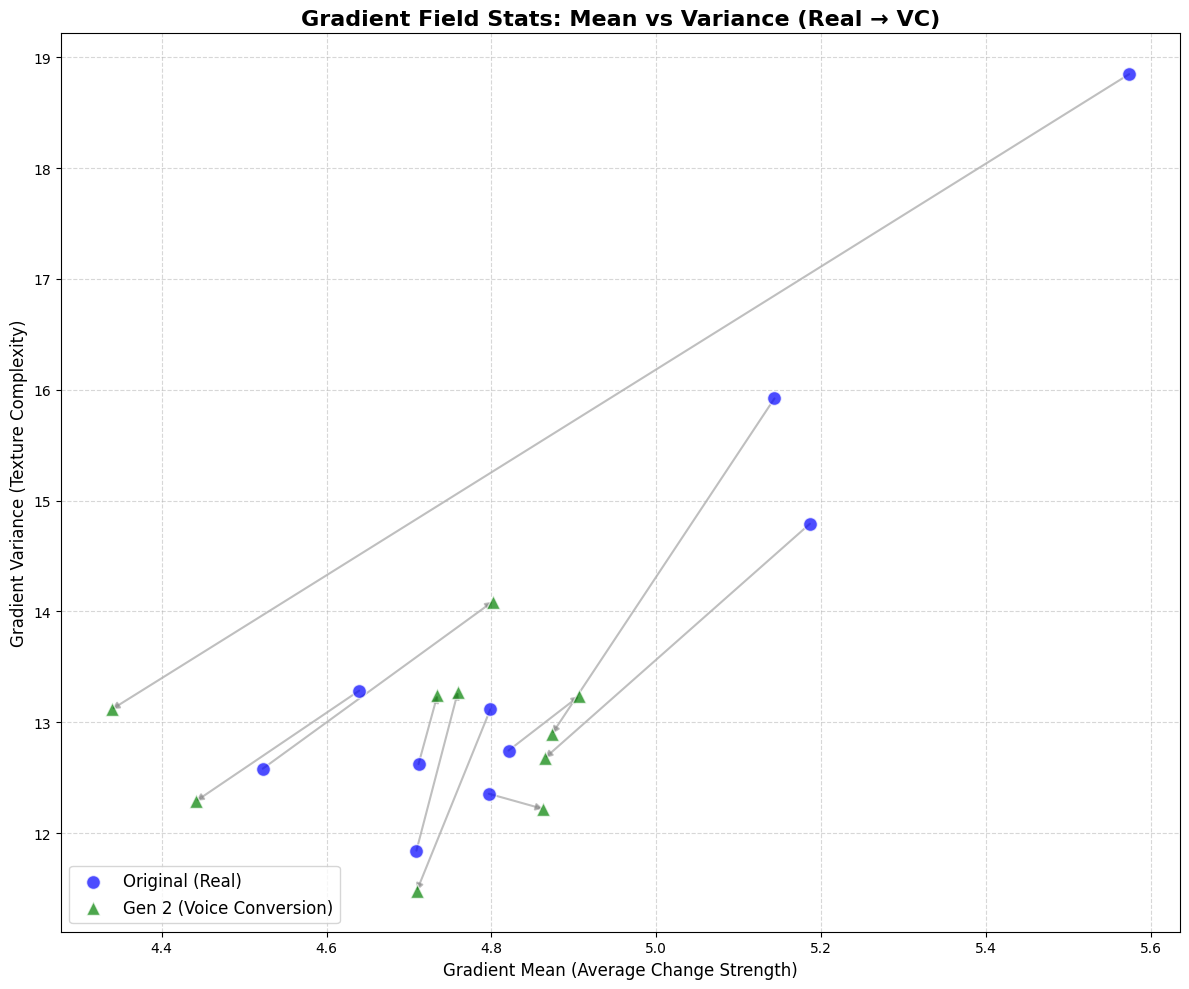

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# 데이터를 저장할 딕셔너리 (파일명 기준으로 매칭하기 위함)
# 구조: { 'file_name': {'Original': (mean, var), 'Gen 2': (mean, var)} }
file_metrics = {}

# 색상 및 마커 설정 (Gen 1 제외)
styles = {
    "Original (Real)": {'color': 'blue', 'marker': 'o', 'label': 'Original (Real)'},
    "Gen 2 (Voice Conversion)": {'color': 'green', 'marker': '^', 'label': 'Gen 2 (Voice Conversion)'}
}

print("Collecting data metrics...")

# dataframe_10의 모든 행에 대해 데이터 수집
for i, row in enumerate(dataframe_10.to_dict('records')):
    base_name = Path(row['audio_path']).stem
    
    # 딕셔너리 초기화
    if base_name not in file_metrics:
        file_metrics[base_name] = {}

    # 2가지 타입(Original, Gen 2)의 파일 경로 정의
    file_paths = {
        "Original (Real)": Path(row['audio_path']).resolve(),
        "Gen 2 (Voice Conversion)": Path(f"generated_results/speaker_libri_transcript_{base_name}.wav")
    }
    
    for group_name, path in file_paths.items():
        if not path.exists():
            continue
            
        # 1. Mel Spectrogram 계산
        mel = compute_mel_spectrogram(str(path))
        if mel is None:
            continue
            
        # 2. Gradient Field 수치 추출 (Mean, Variance)
        _, var, mean = compute_gradient_field(mel)
        
        # 3. 데이터 저장 (파일명 키 아래에 그룹별로 저장)
        file_metrics[base_name][group_name] = (mean, var)

    # 진행 상황 표시
    if (i + 1) % 10 == 0:
        print(f"Processed {i + 1} rows...")

print("Data collection complete. Plotting results...")

# --- 시각화 (Scatter Plot + Arrows) ---
plt.figure(figsize=(12, 10))

# 1. 점 찍기 (Scatter)
# 범례(Legend)를 위해 그룹별로 모아서 한 번씩 찍습니다.
for group_name in styles.keys():
    means = []
    vars = []
    
    for name, metrics in file_metrics.items():
        if group_name in metrics:
            means.append(metrics[group_name][0]) # mean
            vars.append(metrics[group_name][1])  # var
            
    if means:
        plt.scatter(means, vars, 
                    c=styles[group_name]['color'], 
                    marker=styles[group_name]['marker'], 
                    label=styles[group_name]['label'], 
                    alpha=0.7, s=100, edgecolors='white', zorder=2)

# 2. 화살표 그리기 (Arrows)
print("Drawing arrows...")
for name, metrics in file_metrics.items():
    # Original과 Gen 2 데이터가 둘 다 있는 경우에만 화살표 연결
    if "Original (Real)" in metrics and "Gen 2 (Voice Conversion)" in metrics:
        start_pos = metrics["Original (Real)"]         # (mean, var)
        end_pos = metrics["Gen 2 (Voice Conversion)"]  # (mean, var)
        
        plt.annotate(
            "", 
            xy=end_pos,            # 화살표 머리 (Gen 2)
            xytext=start_pos,      # 화살표 꼬리 (Original)
            arrowprops=dict(
                arrowstyle="-|>", 
                color='gray', 
                alpha=0.5, 
                linewidth=1.5,
                shrinkA=0, shrinkB=0
            ),
            zorder=1
        )

# 그래프 꾸미기
plt.title("Gradient Field Stats: Mean vs Variance (Real → VC)", fontsize=16, fontweight='bold')
plt.xlabel("Gradient Mean (Average Change Strength)", fontsize=12)
plt.ylabel("Gradient Variance (Texture Complexity)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

Starting feature extraction for PCA (Original vs Gen 2)...
Feature extraction complete. Data shape: (20, 20480)
Running PCA...
Explained variance ratio: [0.12378138 0.07484297]
Drawing arrows...


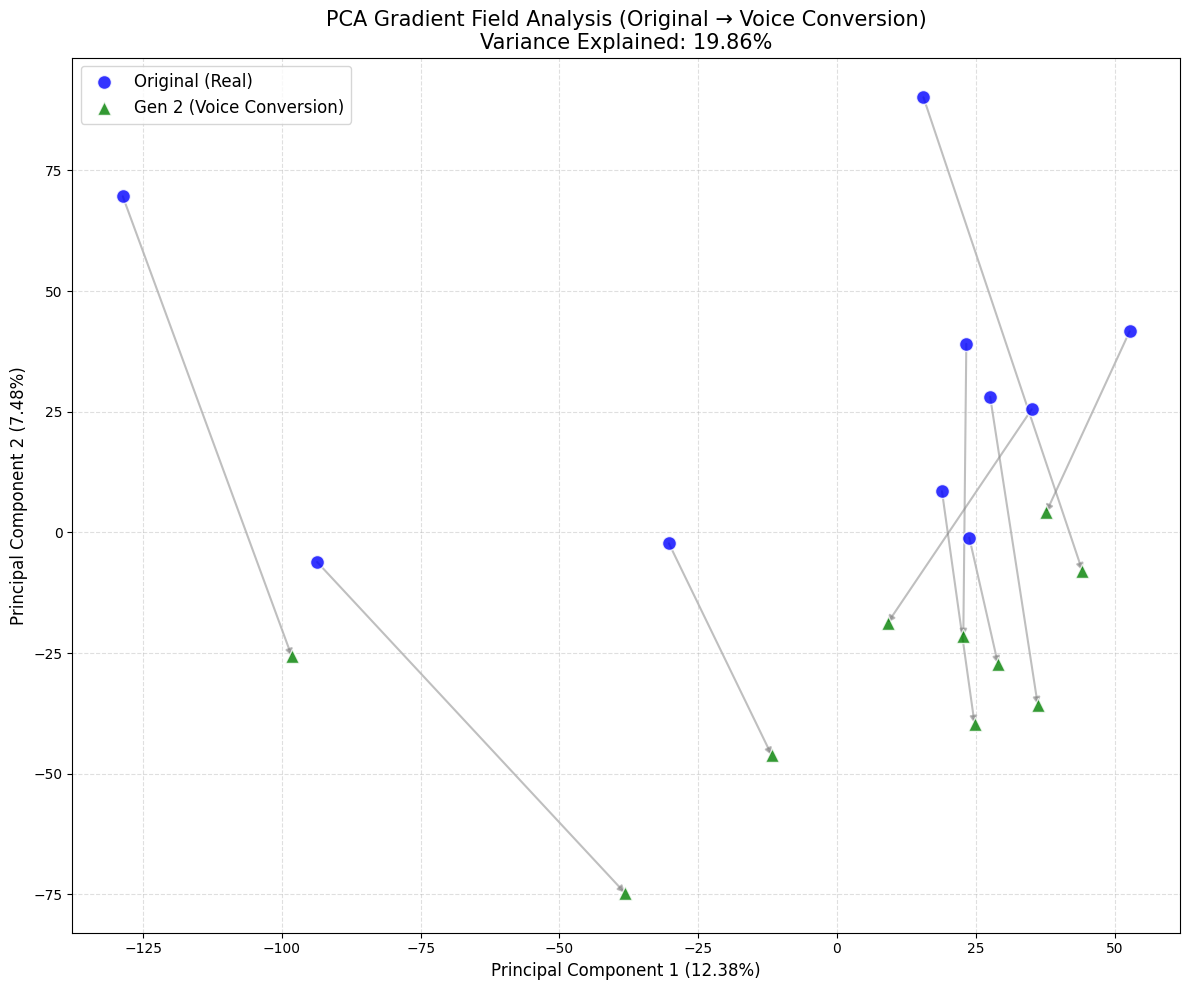

In [13]:
import matplotlib.pyplot as plt
import torchaudio
import torch
import numpy as np
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# --- 1. 설정 및 헬퍼 함수 (기존과 동일) ---

TARGET_WIDTH = 256  

def resize_spectrogram(spec_tensor, target_width=TARGET_WIDTH):
    n_mels, width = spec_tensor.shape
    if width > target_width:
        start = (width - target_width) // 2
        return spec_tensor[:, start:start+target_width]
    elif width < target_width:
        pad_width = target_width - width
        return torch.nn.functional.pad(spec_tensor, (0, pad_width, 0, 0))
    return spec_tensor

def compute_mel_spectrogram_resized(audio_path, n_mels=80, target_width=TARGET_WIDTH):
    try:
        waveform, sr = torchaudio.load(audio_path)
        mel = torchaudio.transforms.MelSpectrogram(
            sample_rate=sr, n_fft=1024, hop_length=256, n_mels=n_mels, normalized=True
        )(waveform)
        mel_db = torchaudio.functional.amplitude_to_DB(mel, multiplier=10.0, amin=1e-10, db_multiplier=1.0)
        mel_db = mel_db.squeeze(0)
        return resize_spectrogram(mel_db, target_width)
    except Exception as e:
        print(f"Error loading {audio_path}: {e}")
        return None

def compute_flattened_gradient(mel_tensor):
    mel_np = mel_tensor.numpy()
    grad_y, grad_x = np.gradient(mel_np)
    gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)
    return gradient_magnitude.flatten()

# --- 2. 데이터 수집 (Original & Gen 2 Only) ---

features = [] 
labels = []   
filenames = [] # 화살표 연결을 위해 파일명 저장

# 분석할 대상 그룹 정의 (Gen 1 제외)
target_groups = ["Original (Real)", "Gen 2 (Voice Conversion)"]
label_map = {name: i for i, name in enumerate(target_groups)}
colors = ['blue', 'green'] # 파랑: 원본, 초록: 변환
markers = ['o', '^']

print("Starting feature extraction for PCA (Original vs Gen 2)...")

for i, row in enumerate(dataframe_10.to_dict('records')):
    base_name = Path(row['audio_path']).stem
    
    # 두 가지 경로만 설정
    file_paths = {
        "Original (Real)": Path(row['audio_path']).resolve(),
        "Gen 2 (Voice Conversion)": Path(f"generated_results/speaker_libri_transcript_{base_name}.wav")
    }
    
    for group_name, path in file_paths.items():
        if not path.exists(): continue
            
        mel = compute_mel_spectrogram_resized(str(path))
        if mel is None: continue
            
        flattened_vec = compute_flattened_gradient(mel)
        
        features.append(flattened_vec)
        labels.append(label_map[group_name])
        filenames.append(base_name) # 파일명 저장

X = np.array(features)
y = np.array(labels)

print(f"Feature extraction complete. Data shape: {X.shape}")

# --- 3. PCA 수행 ---

print("Running PCA...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

explained_variance = pca.explained_variance_ratio_
print(f"Explained variance ratio: {explained_variance}")

# --- 4. 시각화 (화살표 포함) ---

plt.figure(figsize=(12, 10))

# 4-1. 산점도 그리기
for target_idx, group_name in enumerate(target_groups):
    mask = (y == target_idx)
    plt.scatter(
        X_pca[mask, 0], 
        X_pca[mask, 1],
        color=colors[target_idx],
        marker=markers[target_idx],
        label=group_name,
        alpha=0.8, s=100, edgecolors='white',
        zorder=2
    )

# 4-2. 화살표 그리기 (Original -> Gen 2)
print("Drawing arrows...")
unique_files = sorted(list(set(filenames)))

for base_name in unique_files:
    # 현재 파일명에 해당하는 인덱스 찾기
    orig_indices = [idx for idx, (f, l) in enumerate(zip(filenames, labels)) if f == base_name and l == 0]
    gen2_indices = [idx for idx, (f, l) in enumerate(zip(filenames, labels)) if f == base_name and l == 1]

    if orig_indices and gen2_indices:
        start_pos = X_pca[orig_indices[0]] # Original 위치
        end_pos = X_pca[gen2_indices[0]]   # Gen 2 위치

        plt.annotate(
            "", 
            xy=end_pos, 
            xytext=start_pos,
            arrowprops=dict(
                arrowstyle="-|>", 
                color='gray', 
                alpha=0.5, 
                linewidth=1.5,
                shrinkA=0, shrinkB=0
            ),
            zorder=1
        )

# 그래프 꾸미기
plt.title(f"PCA Gradient Field Analysis (Original → Voice Conversion)\nVariance Explained: {sum(explained_variance)*100:.2f}%", fontsize=15)
plt.xlabel(f"Principal Component 1 ({explained_variance[0]*100:.2f}%)", fontsize=12)
plt.ylabel(f"Principal Component 2 ({explained_variance[1]*100:.2f}%)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

Extracting features...
Data shape: (20, 20480)
Running t-SNE (Perplexity: 19)...
Drawing arrows...


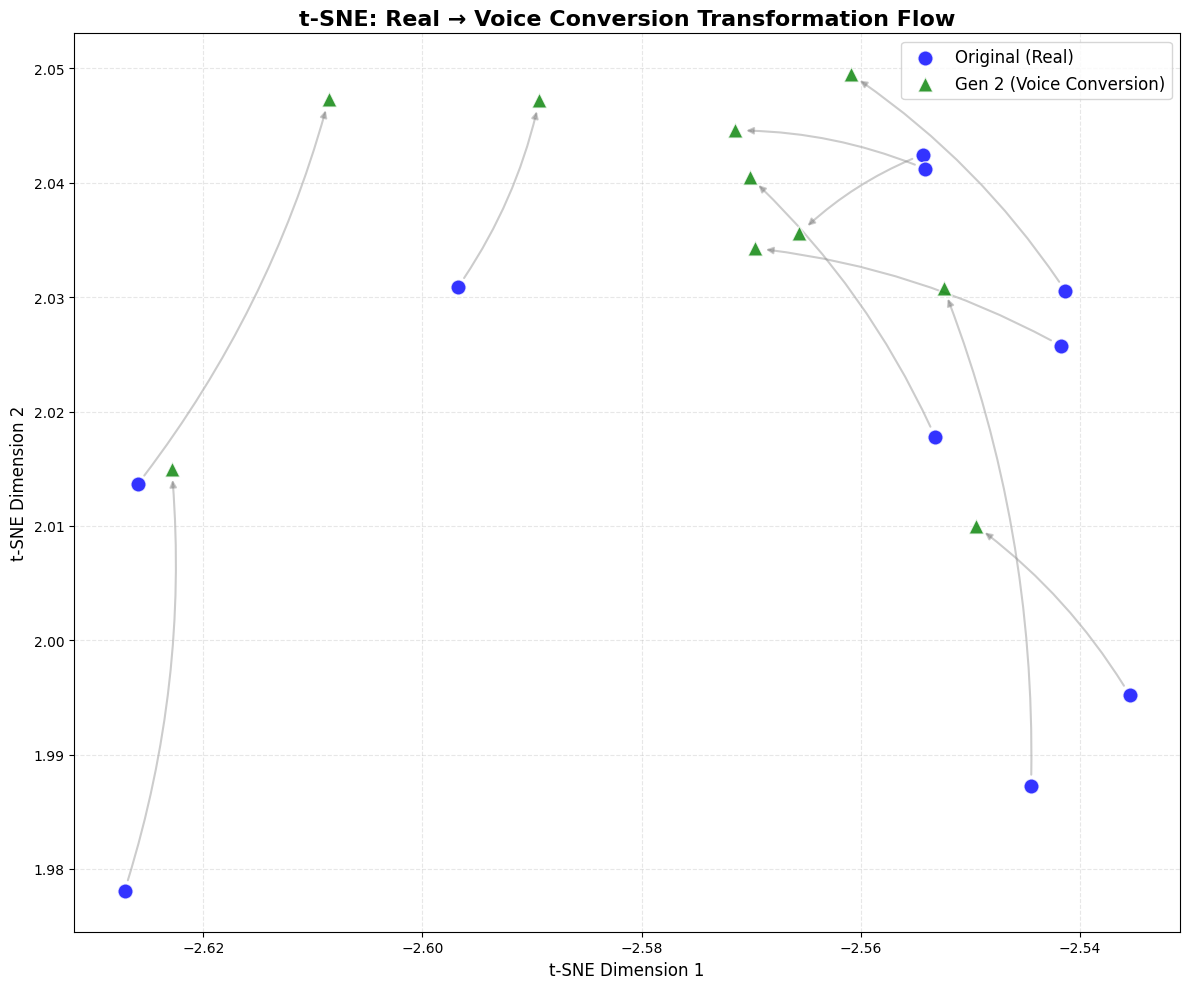

In [14]:
import matplotlib.pyplot as plt
import torchaudio
import torch
import numpy as np
from pathlib import Path
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# --- 1. 설정 및 헬퍼 함수 (기존과 동일) ---

TARGET_WIDTH = 256

def resize_spectrogram(spec_tensor, target_width=TARGET_WIDTH):
    n_mels, width = spec_tensor.shape
    if width > target_width:
        start = (width - target_width) // 2
        return spec_tensor[:, start:start+target_width]
    elif width < target_width:
        pad_width = target_width - width
        return torch.nn.functional.pad(spec_tensor, (0, pad_width, 0, 0))
    return spec_tensor

def compute_mel_and_flatten_grad(audio_path, n_mels=80):
    try:
        waveform, sr = torchaudio.load(audio_path)
        mel = torchaudio.transforms.MelSpectrogram(
            sample_rate=sr, n_fft=1024, hop_length=256, n_mels=n_mels, normalized=True
        )(waveform)
        mel_db = torchaudio.functional.amplitude_to_DB(mel, multiplier=10.0, amin=1e-10, db_multiplier=1.0)
        mel_resized = resize_spectrogram(mel_db.squeeze(0))
        mel_np = mel_resized.numpy()
        grad_y, grad_x = np.gradient(mel_np)
        grad_mag = np.sqrt(grad_x**2 + grad_y**2)
        return grad_mag.flatten()
    except Exception as e:
        return None

# --- 2. 데이터 수집 (Original vs Gen 2) ---

features = []
labels = []
filenames = [] # 화살표 연결을 위해 파일명 저장

target_groups = ["Original (Real)", "Gen 2 (Voice Conversion)"]
label_map = {name: i for i, name in enumerate(target_groups)}
colors = ['blue', 'green']
markers = ['o', '^']

print("Extracting features...")
for row in dataframe_10.to_dict('records'):
    base_name = Path(row['audio_path']).stem
    file_paths = {
        "Original (Real)": Path(row['audio_path']).resolve(),
        "Gen 2 (Voice Conversion)": Path(f"generated_results/speaker_libri_transcript_{base_name}.wav")
    }
    for group_name, path in file_paths.items():
        if not path.exists(): continue
        vec = compute_mel_and_flatten_grad(str(path))
        if vec is not None:
            features.append(vec)
            labels.append(label_map[group_name])
            filenames.append(base_name) # 파일명도 함께 저장

X = np.array(features)
y = np.array(labels)
print(f"Data shape: {X.shape}")

# --- 3. t-SNE 실행 ---

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

n_components_pca = min(50, len(X), X.shape[1])
pca = PCA(n_components=n_components_pca)
X_pca = pca.fit_transform(X_scaled)

perplexity_val = min(30, len(X) - 1)
print(f"Running t-SNE (Perplexity: {perplexity_val})...")
tsne = TSNE(n_components=2, perplexity=perplexity_val, random_state=42, init='pca', learning_rate='auto')
X_embedded = tsne.fit_transform(X_pca)

# --- 4. 시각화 (화살표 추가) ---

plt.figure(figsize=(12, 10)) # 화살표가 잘 보이도록 크기 증가

# 4-1. 점 찍기 (산점도)
for idx, group_name in enumerate(target_groups):
    mask = (y == idx)
    plt.scatter(
        X_embedded[mask, 0], X_embedded[mask, 1],
        c=colors[idx], label=group_name, marker=markers[idx],
        s=120, alpha=0.8, edgecolors='white',
        zorder=2 # 화살표 위에 점이 오도록 순서 지정
    )

# 4-2. 화살표 그리기 (Original -> Gen 2)
print("Drawing arrows...")
# 중복 없는 파일명 리스트 추출
unique_files = sorted(list(set(filenames)))

for base_name in unique_files:
    # 현재 파일명에 해당하는 Original(label=0)과 Gen 2(label=1)의 데이터 인덱스 찾기
    orig_indices = [i for i, (f, l) in enumerate(zip(filenames, labels)) if f == base_name and l == 0]
    gen2_indices = [i for i, (f, l) in enumerate(zip(filenames, labels)) if f == base_name and l == 1]

    # 쌍이 온전하게 존재할 경우에만 화살표 그리기
    if orig_indices and gen2_indices:
        start_pos = X_embedded[orig_indices[0]] # 시작점 (Original 좌표)
        end_pos = X_embedded[gen2_indices[0]]   # 끝점 (Gen 2 좌표)

        # 화살표 그리기
        plt.annotate(
            "",  # 텍스트 내용 없음
            xy=end_pos,           # 화살표 머리 위치
            xytext=start_pos,     # 화살표 꼬리 위치
            arrowprops=dict(
                arrowstyle="-|>",         # 뾰족한 화살표 모양
                color='gray',             # 화살표 색상
                alpha=0.4,                # 투명도 (너무 진하면 방해됨)
                linewidth=1.5,            # 선 두께
                shrinkA=8, shrinkB=8,     # 점과 화살표 사이 여백 주기
                connectionstyle="arc3,rad=0.1" # 약간 휘어진 화살표 (직선이 좋으면 이 줄 삭제)
            ),
            zorder=1 # 점 아래에 그려지도록 설정
        )

# 4-3. 그래프 꾸미기
plt.title("t-SNE: Real → Voice Conversion Transformation Flow", fontsize=16, fontweight='bold')
plt.xlabel("t-SNE Dimension 1", fontsize=12)
plt.ylabel("t-SNE Dimension 2", fontsize=12)
plt.legend(fontsize=12, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()